# 2 - Approches de modélisation
Ce notebook explore les différents modèles et ajustements qui ont été effectués afin de parvenir à la sélection du modèle optimal.

In [2]:
# Chargement des bibliothèques
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn import preprocessing
from sklearn import decomposition

sns.set()
palette = sns.color_palette("bright", 4)

from olist import Olist

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
%load_ext pycodestyle_magic
%pycodestyle_on

In [6]:
olist = Olist()

# Load dataset
raw_orders = olist.merge_dataset()

# Only delivered orders
orders = raw_orders[raw_orders['order_status'] == 'delivered']

# Select analysis period
purchase_end_date = orders['order_purchase_timestamp'].max()
purchase_start_date = purchase_end_date + relativedelta(months=-12)
purchase_end_date = purchase_start_date + relativedelta(months=3)

start_date = purchase_start_date.strftime('%d/%m/%Y')
end_date = purchase_end_date.strftime('%d/%m/%Y')

print(f"Période de référence du {start_date} au {end_date}")

period = orders[(
    orders['order_purchase_timestamp'] >= purchase_start_date) & (
    orders['order_purchase_timestamp'] <= purchase_end_date)]

print(f"{len(period['customer_unique_id'].unique())} clients")
print(f"{len(period['order_id'].unique())} Commandes")

Période de référence du 29/08/2017 au 29/11/2017
15572 clients
15898 Commandes


# Introduction
L'analyse porte sur 15 898 commandes de 15 572 clients pendant la période du 29/08/2017 au 28/11/2017, soit 3 mois.

# RFM
La segmentation RFM prend en compte la **Récence** (date de la dernière commande), la **Fréquence** des commandes et le **Montant** (de la dernière commande ou sur une période donnée) pour établir des segments de clients homogènes.

In [7]:
def RFM_level(df):
    """
    Classement des clients en fonction de leur score de
    Recency, Frequency et Monetary
    """
    if (df['R_score'] == 4) & (df['F_score'] == 4) & (df['M_score'] == 4):
        return 'Meilleur client fréquent'
    if (df['R_score'] == 4) & (df['F_score'] == 1) & (df['M_score'] == 4):
        return 'Meilleur client ponctuel'

    if (df['R_score'] >= 3) & (df['F_score'] == 4) & (df['M_score'] >= 3):
        return 'Bon client fréquent'
    if (df['R_score'] >= 3) & (df['F_score'] == 1) & (df['M_score'] >= 3):
        return 'Bon client ponctuel'

    if (df['R_score'] >= 1) & (df['F_score'] == 4) & (df['M_score'] >= 3):
        return 'Ancien bon client fréquent'
    if (df['R_score'] >= 1) & (df['F_score'] == 1) & (df['M_score'] >= 3):
        return 'Ancien bon client ponctuel'

    if (df['R_score'] >= 3) & (df['F_score'] == 4) & (df['M_score'] <= 3):
        return 'Bon client à faible montant'

    if df['R_score'] <= 2:
        return 'Client perdu'

    if df['F_score'] == 1:
        return 'Client qui achète qu\'une seule fois'

    return 'ERROR'

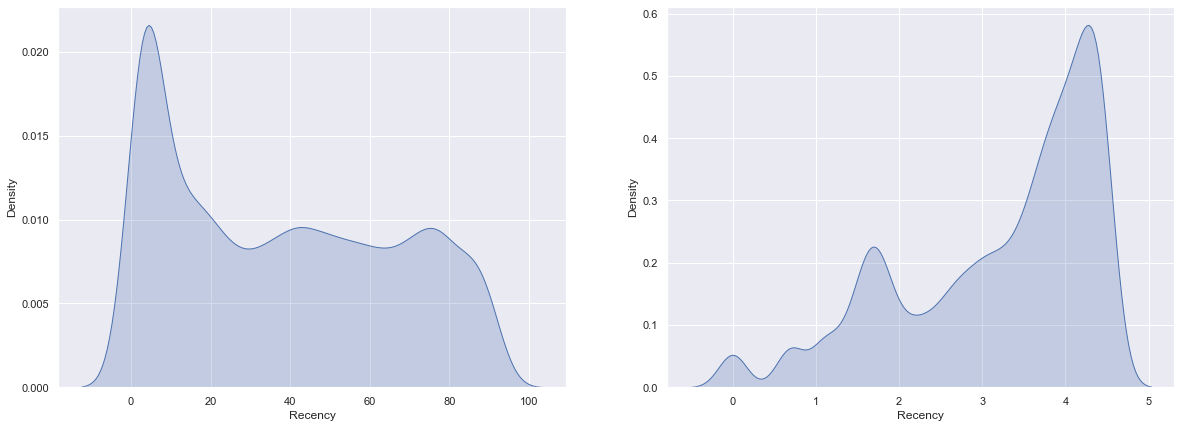

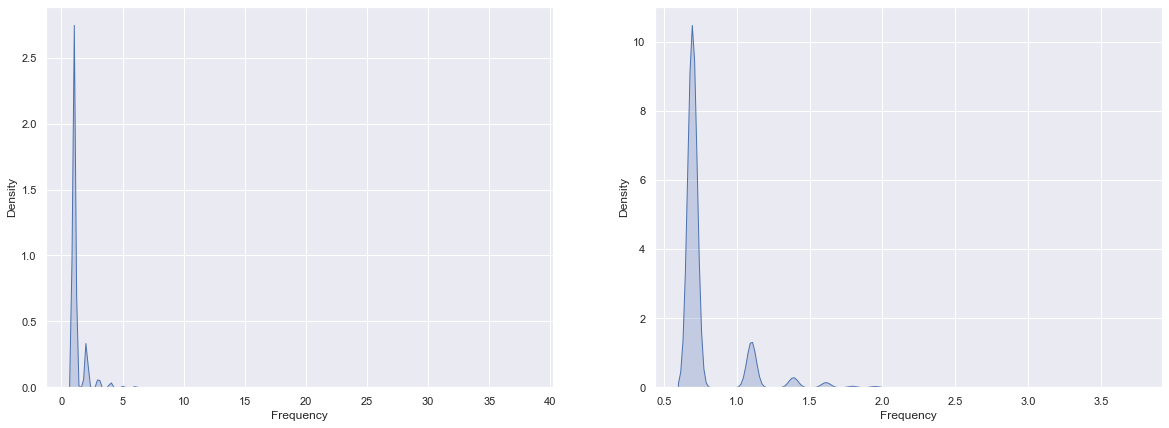

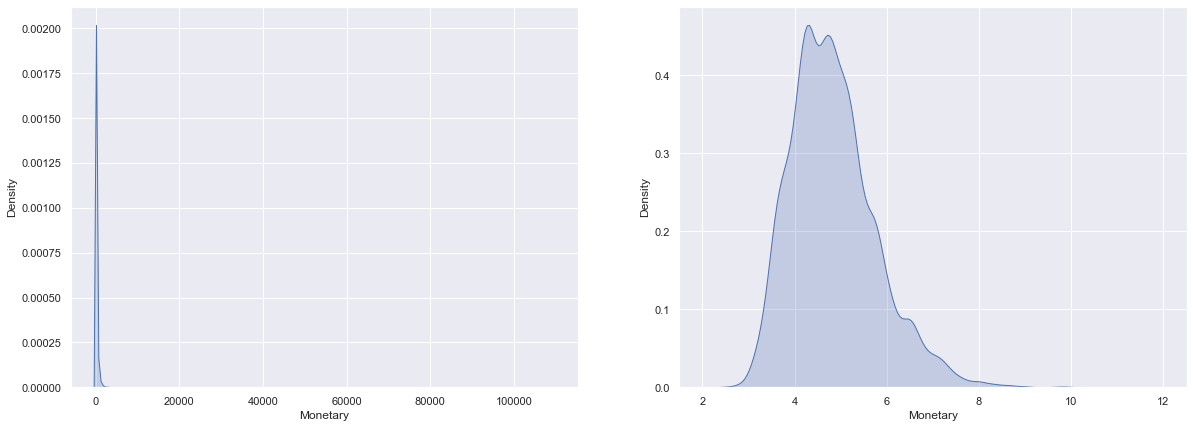

In [8]:
RFM = olist.get_RFM(period, purchase_end_date)

# Création des groupes
RFM['cluster'] = RFM.apply(RFM_level, axis=1)

# Ajout des données RFM au jeu de données
period = period.merge(
    RFM,
    left_on='customer_unique_id',
    right_on='customer_unique_id',
    how='left'
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
sns.kdeplot(RFM['Recency'], shade=True, ax=ax1)
sns.kdeplot(np.log1p(RFM['Recency']), shade=True, ax=ax2)
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
sns.kdeplot(RFM['Frequency'], shade=True, ax=ax1)
sns.kdeplot(np.log1p(RFM['Frequency']), shade=True, ax=ax2)
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
sns.kdeplot(RFM['Monetary'], shade=True, ax=ax1)
sns.kdeplot(np.log1p(RFM['Monetary']), shade=True, ax=ax2)
plt.show()

La distribution des données pour **Fréquence** et le **Montant** sont très asymétriques. Une transformation log sur la colonne Monetary permet de recentrer les données.

## Segmentation manuelle
Compte tenu qu'il y a beaucoup d'achats uniques, nous avons défini pour chaque groupe un type fréquent et ponctuel.

| Segment | Catégorie                      | clientèle |
| :------ | :----------------------------- | :-------- |
|  1      | Meilleur                       | Fréquent  |
|  2      | Meilleur                       | Ponctuel  |
|  3      | Bon                            | Fréquent  |
|  4      | Bon                            | Ponctuel  |
|  5      | Ancien bon                     | Fréquent  |
|  6      | Ancien bon                     | Ponctuel  |
|  7      | Bon à faible montant           | Fréquent  |
|  8      | Qui n'achète qu'une seule fois | Ponctuel  |
|  9      | Perdu                          | -         |


## Analyse de la segmentation

In [8]:
segment = period.groupby(['cluster']).agg(
    customers_count=pd.NamedAgg(column='customer_id',
                                aggfunc='count'),
    Recency=pd.NamedAgg(column='Recency',
                        aggfunc='mean'),
    Frequency=pd.NamedAgg(column='Frequency',
                          aggfunc='mean'),
    Monetary=pd.NamedAgg(column='Monetary',
                         aggfunc='mean'),
    Price=pd.NamedAgg(column='price',
                      aggfunc='mean'),
    product_category_mode=pd.NamedAgg(column='product_category_name',
                                      aggfunc=lambda x: x.mode()[0]),
    payment_type=pd.NamedAgg(column='payment_type',
                             aggfunc=lambda x: x.mode()[0]),
    seller_city=pd.NamedAgg(column='seller_city',
                            aggfunc=lambda x: x.mode()[0]),
    customer_city=pd.NamedAgg(column='customer_city',
                              aggfunc=lambda x: x.mode()[0])
)

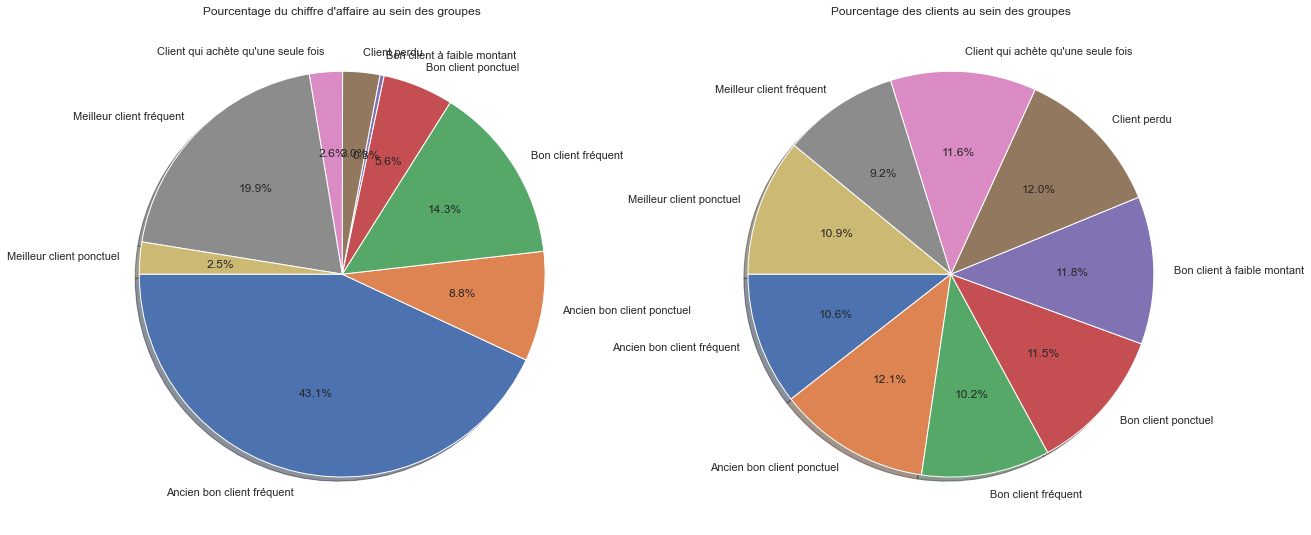

In [9]:
olist.display_customers(
    period,
    period['cluster'].sort_values().unique(),
    'Monetary')

## Conclusion
La segmentation RFM telle que définie montre une répartition homogène au niveau des clients mais une grande part d'**"anciens bons clients fréquents"** au niveau chiffre d'affaires. 

# Regroupement par clients

Afin d'analyser le comportement des clients les données vont être regroupées par client, les données agrégées seront soit une moyenne, soit la valeur la plus fréquente, soit une somme.

In [10]:
customer_data = olist.get_customer_data(period)

# Test des algorithmes
On effectuera différents tests avec les algorithmes : K-means, DBSCAN et CAH ainsi que des variantes avec un changement du nombre de groupes, du nombre de variables ou du type de normalisation.

# Test K-means avec uniquement les variables RFM
Premier test de classification en ne prenant que les variables RFM précédemment calculées.

In [11]:
features = [
    'Recency',
    'Frequency',
    'Monetary'
]
data = customer_data[features]

Silhouette Score(n=2): 0.581270886396111
Silhouette Score(n=3): 0.5066073487300374
Silhouette Score(n=4): 0.4215441690607569
Silhouette Score(n=5): 0.40837443570788434
Silhouette Score(n=6): 0.3836502788447384


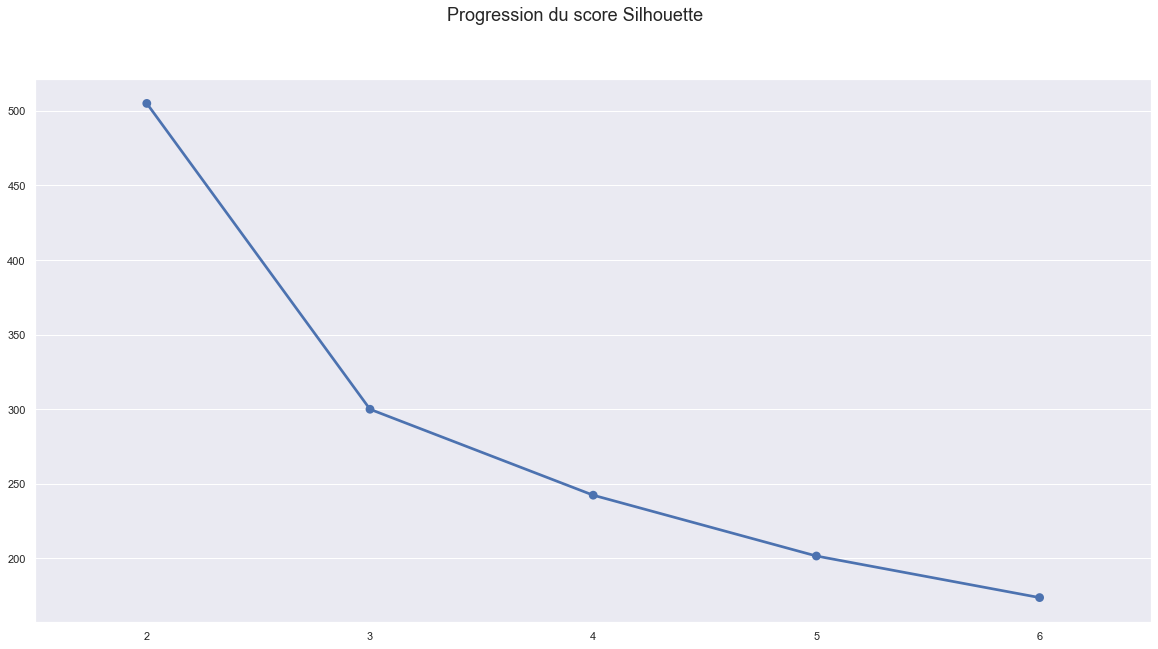

In [12]:
olist.use_kmeans(data)

En utilisant  uniquement les variables **Recency**, **Fréquency** et **Monetary**, le nombre de groupes optimal selon le score silhouette est de **2**, alors que par la méthode "elbow" **3** semble être le nombre de groupe optimal.

## Test avec 3 groupes

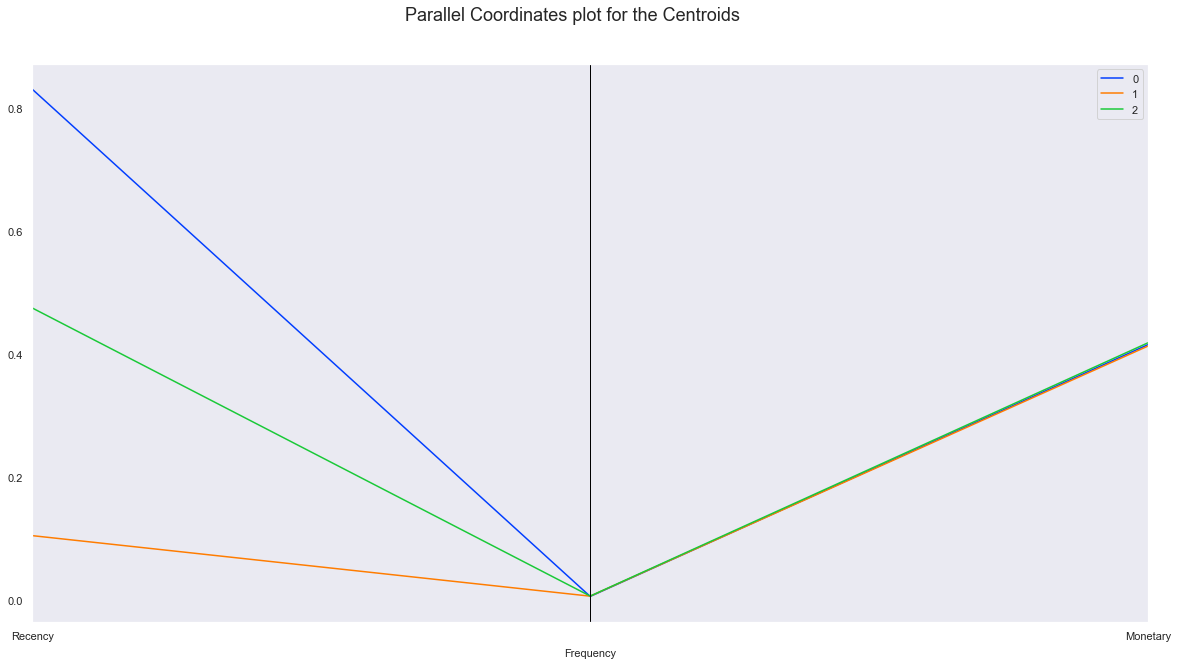

In [13]:
olist.nb_cluster = 3
labels = olist.display_kmeans_centroids(data)

In [14]:
data['cluster'] = pd.Series(labels, index=data.index)
clusters = data.groupby('cluster').mean()
print(clusters)

           Recency  Frequency  Monetary
cluster                                
0        75.647477   1.236239  1.578057
1         9.574577   1.250000  1.573335
2        43.264603   1.252833  1.582327


## Conclusion
Avec un groupe de 3 on ne distingue qu'une différence dans la récence, la fréquence et le montant étant très proche entre eux. Cette division en 3 groupes montre des valeurs relativement similaires, de ce fait les données ne sont pas exploitables, il faut donc ajouter d'autres variables pour construire les groupes.

# Test K-means avec toutes les variables
Le premier test de classification en ne prenant que les variables RFM précédemment calculées ne permettant pas d'obtenir des éléments de segmentation, le deuxième essai est fait avec toutes les variables.

Les variables catégorielles sont transformées avec la méthode "OneHotEncoding"

In [15]:
data = customer_data.copy()

data.drop([
    'customer_unique_id',
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    'order_item_id',
    'product_id',
    'seller_id',
    'shipping_limit_date',
    'review_creation_date',
    'review_answer_timestamp'
   ],
   axis=1,
   inplace=True)

data = pd.get_dummies(data, columns=[
    'customer_zip_code_prefix',
    'order_status',
    'customer_city',
    'customer_state',
    'seller_zip_code_prefix',
    'seller_city',
    'seller_state',
    'payment_type'
])

data.dropna(inplace=True)

Silhouette Score(n=2): 0.07328800424841712
Silhouette Score(n=3): 0.04799229937981635
Silhouette Score(n=4): 0.03670427521814958
Silhouette Score(n=5): 0.04389272219429668
Silhouette Score(n=6): 0.047311738505427865


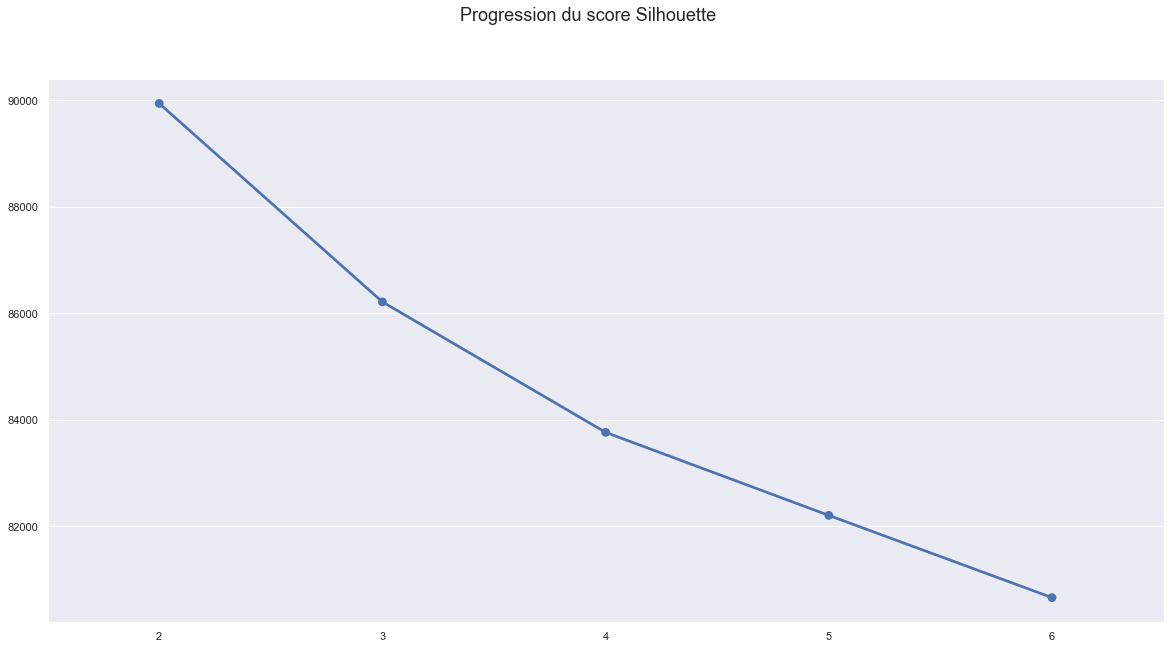

In [16]:
olist.use_kmeans(data)

Le silhouette score avec la méthode K-means et toutes les variables, propose 2 groupes, la méthode "Elbow" suggère quant à elle 3 groupes. 

## Conclusion

Les scores de silhouette ou de la méthode "Elbow" montre des scores vraiment très faibles. Il faut donc réduire le nombre de variables pour obtenir un score correct.

# Test avec uniquement les valeurs numériques

In [17]:
data = customer_data.select_dtypes(include=np.number)
data.dropna(inplace=True)
display(data.columns)
print(f"{len(data.columns)} variables")

Index(['order_id', 'customer_id', 'order_purchase_approved_minutes',
       'order_purchase_carrier_days', 'order_purchase_delivered_days',
       'order_carrier_delivered_days', 'order_delivered_estimated_days',
       'order_item_id', 'price', 'freight_value', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_volume', 'seller_zip_code_prefix', 'payment_sequential',
       'payment_installments', 'payment_value', 'review_score',
       'review_have_title', 'review_have_message',
       'review_creation_answer_days', 'customer_zip_code_prefix', 'Recency',
       'Frequency', 'Monetary'],
      dtype='object')

30 variables


Silhouette Score(n=2): 0.3118678437984664
Silhouette Score(n=3): 0.28068812971044327
Silhouette Score(n=4): 0.2162104197924985
Silhouette Score(n=5): 0.19899540589794087
Silhouette Score(n=6): 0.20562770350266846


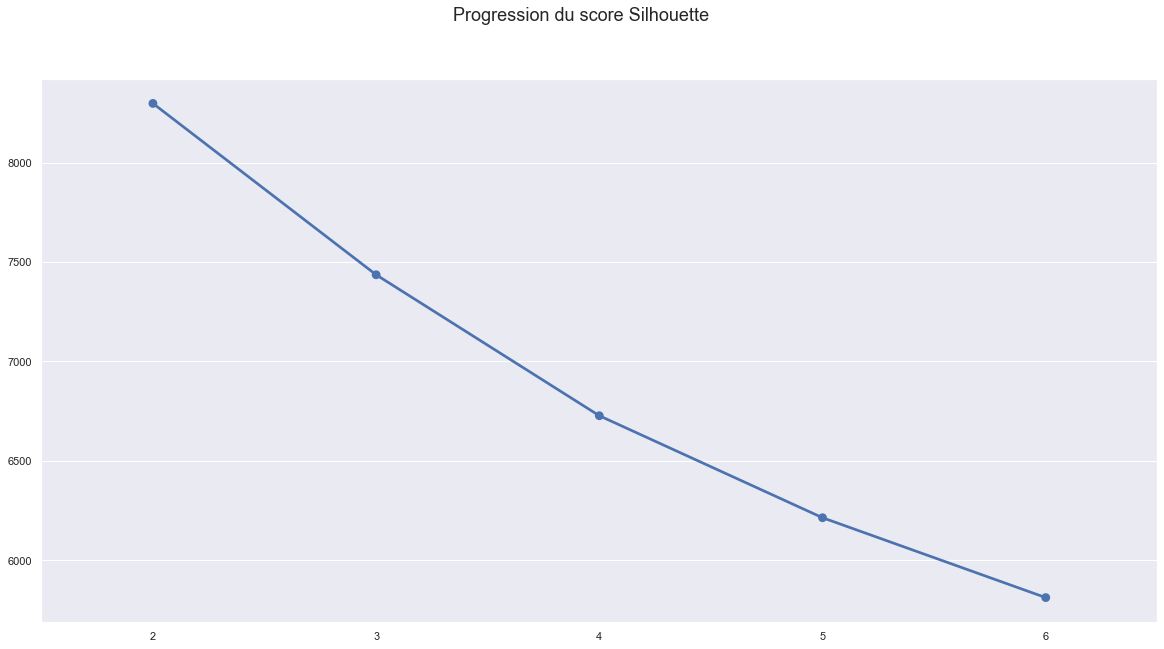

In [18]:
olist.use_kmeans(data)

Comme précedement le score Silhouette propose une segmention à **2** groupes alors que la méthode "Elbow" semble proposer **4** groupes.

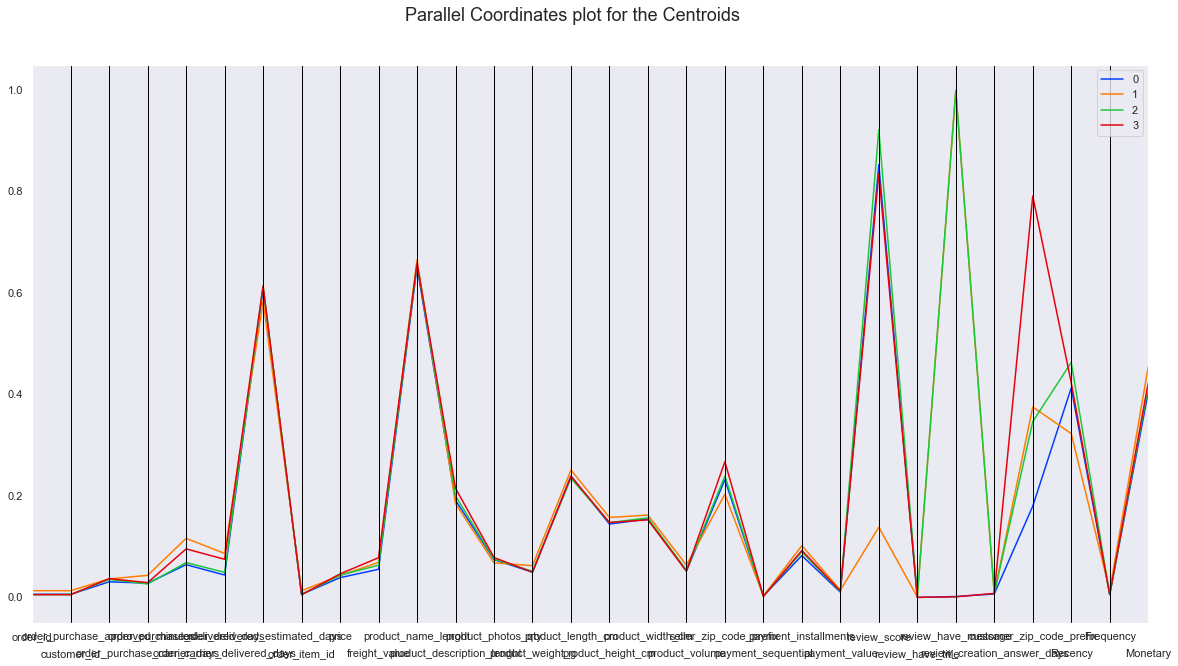

In [19]:
olist.nb_cluster = 4
labels = olist.display_kmeans_centroids(data)

## Conclusion
En utilisant toutes les variables numériques on obtient une segmentation qui peut être difficilement interprétable étant donné le nombre de variables et leur proximité entres elles. Dans l'exemple ci-dessus la valeur de **product_name** semble identique pour tous les groupes.

# Test avec réduction de dimension
Le nombre de variables étant trop important pour extraire des informations pertinentes, nous allons utiliser une ACP pour mettre en évidence les variables les plus importantes.

In [20]:
data = customer_data.select_dtypes(include=np.number)
data.dropna(inplace=True)
data.columns

Index(['order_id', 'customer_id', 'order_purchase_approved_minutes',
       'order_purchase_carrier_days', 'order_purchase_delivered_days',
       'order_carrier_delivered_days', 'order_delivered_estimated_days',
       'order_item_id', 'price', 'freight_value', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_volume', 'seller_zip_code_prefix', 'payment_sequential',
       'payment_installments', 'payment_value', 'review_score',
       'review_have_title', 'review_have_message',
       'review_creation_answer_days', 'customer_zip_code_prefix', 'Recency',
       'Frequency', 'Monetary'],
      dtype='object')

In [21]:
# Data normalization
std_scale = preprocessing.StandardScaler().fit(data)
data_scaled = std_scale.transform(data)

# Apply PCA whith 6 components
pca = decomposition.PCA(n_components=12)
pca.fit(data_scaled)

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())
ratio = pca.explained_variance_ratio_.sum()*100
print(f"{ratio:.2f}% d'explication avec 12 variables")
data_pca = pca.fit_transform(data_scaled)

[0.15217467 0.14016826 0.09781027 0.06386729 0.04936907 0.04397285
 0.04023897 0.03879725 0.03590655 0.03552062 0.03188568 0.03016731]
0.7598788040840632
75.99% d'explication avec 12 variables


Silhouette Score(n=2): 0.17439372123054123
Silhouette Score(n=3): 0.18419404392033492
Silhouette Score(n=4): 0.1708580556953831
Silhouette Score(n=5): 0.1657866355631689
Silhouette Score(n=6): 0.1517742328081937


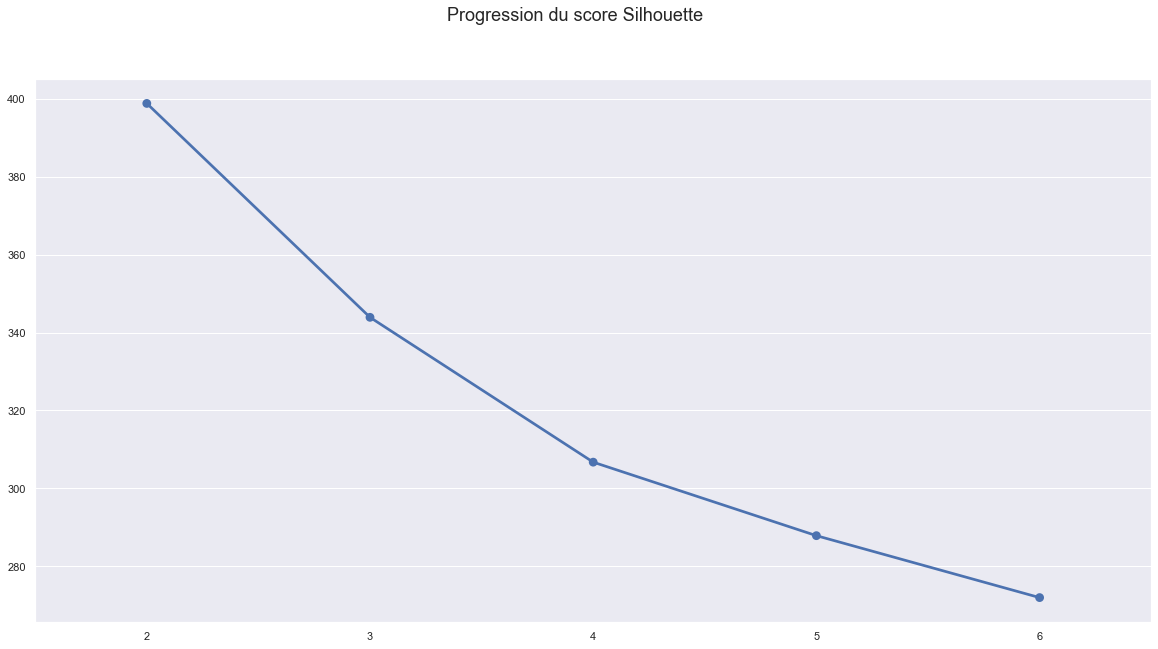

In [22]:
olist.use_kmeans(data_pca)

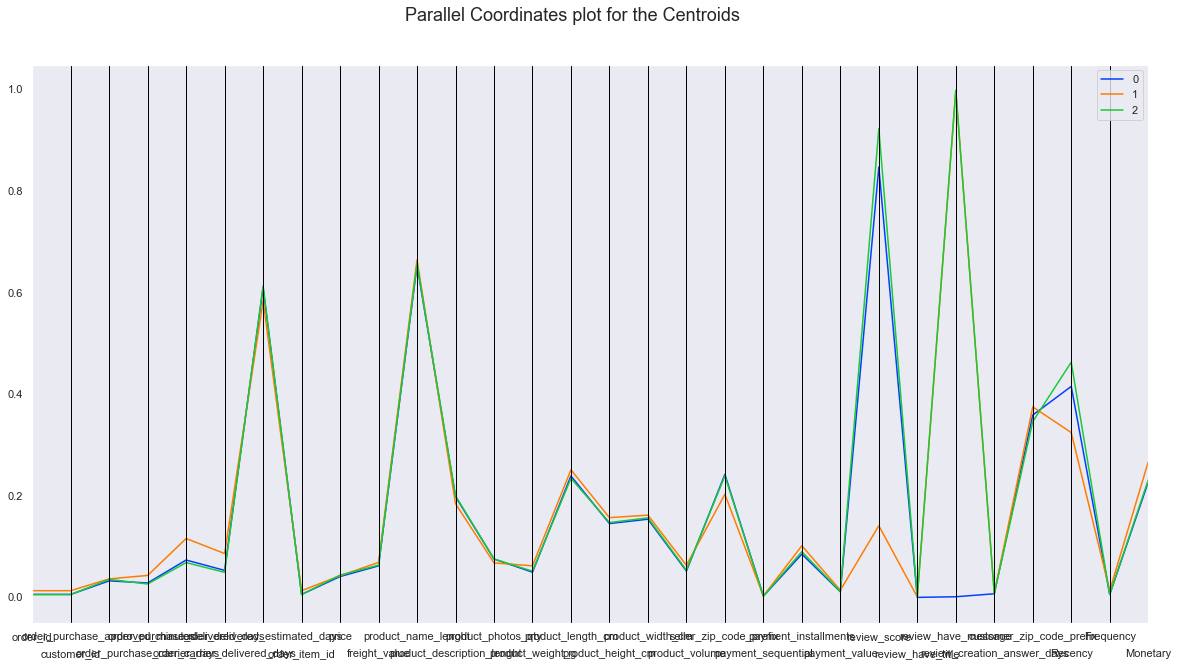

In [23]:
olist.nb_cluster = 3
labels = olist.display_kmeans_centroids(data)

Le silhouette score et la méthode "Elbow" avec la méthode K-means et une réduction de dimension proposent 3 groupes.

## Conclusion
La réduction de dimension montre qu'avec 12 variables il est possible d'expliquer 75% des données. Il convient de réduire le nombre de variables pour obtenir un modèle utilisable et compréhensible. 

# K-means et 5 variables
Après de nombreux essais, la combinaison de 5 variables permet de faire émerger des groupes explicables.
 - Nombre de jours pour la livraison de la commande
 - Score
 - Fréquence
 - Montant
 - Récence    

In [24]:
features = [
    'order_purchase_delivered_days',
    'review_score',
    'Frequency',
    'Monetary',
    'Recency'
]
data = customer_data[features]
data.dropna(inplace=True)

Silhouette Score(n=2): 0.4509539147270332
Silhouette Score(n=3): 0.4548965935583492
Silhouette Score(n=4): 0.45642089723454443
Silhouette Score(n=5): 0.41997731182323367
Silhouette Score(n=6): 0.3928903461006897


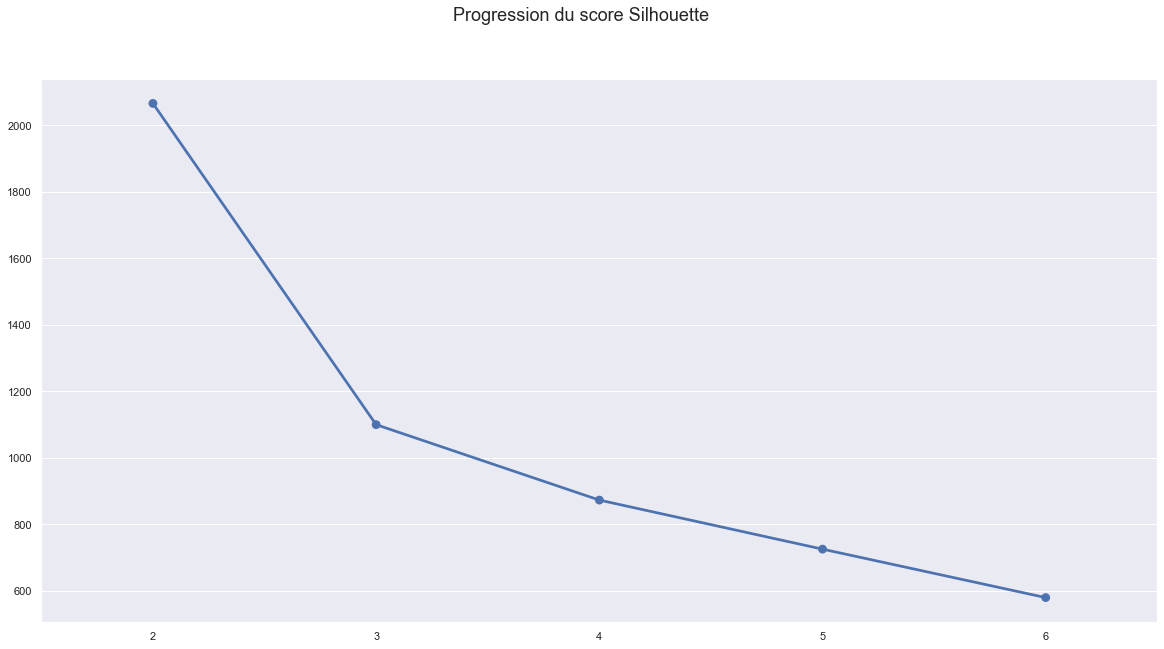

In [25]:
olist.use_kmeans(data)

Le silhouette score propose une segmentation avec 4 groupes alors qu'avec la méthode "Elbow" ce sont 3 groupes

## Test avec 4 groupes

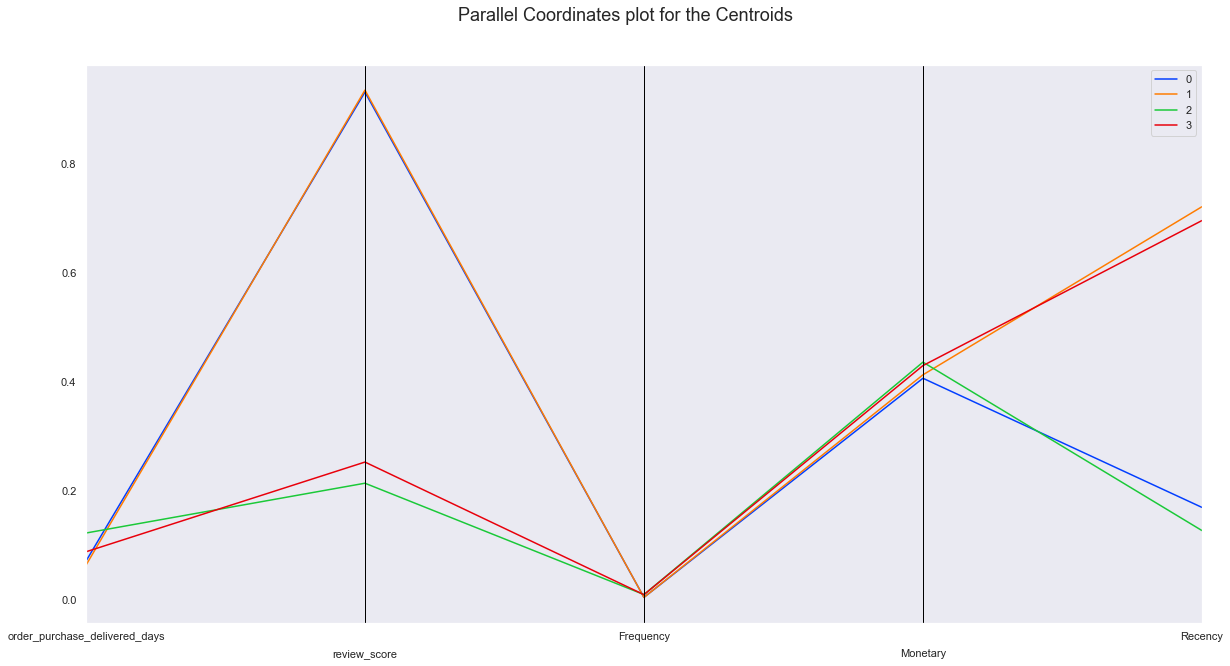

In [26]:
olist.nb_cluster = 4
labels = olist.display_kmeans_centroids(data, image_name='none')
data['cluster'] = pd.Series(labels, index=data.index)

Text(0.5, 1.0, 'Normalisation Robust avec 4 groupes')

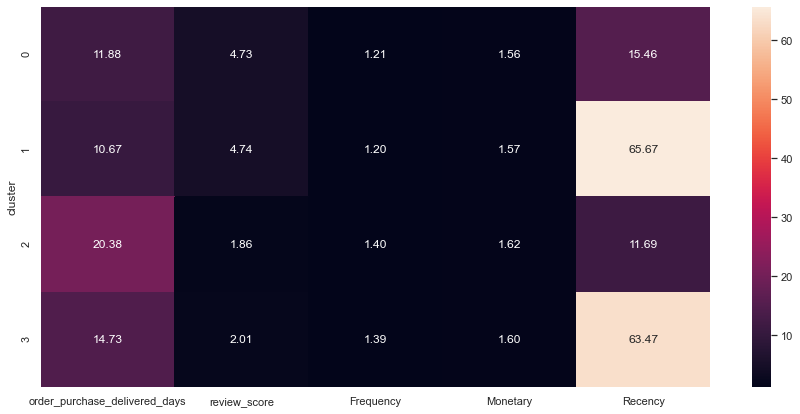

In [27]:
p0 = data.groupby('cluster').mean()
plt.subplots(figsize=(15, 7))
sns.heatmap(data=p0.sort_index(), annot=True, fmt='.2f')
ax1.set_title('Normalisation Robust avec 4 groupes', pad=20)

Découpage en 4 groupes :

**Groupe 0** :
 - Livraison rapide
 - Bonne note
 - Ne commande pas souvent
 - Faible montant
 - n'a pas commandé récemment
 
**Groupe 1** :
 - Livraison standard
 - Mauvaise note
 - Ne commande pas souvent
 - Montant moyen
 - n'a pas commandé récemment

**Groupe 2** :
 - Livraison rapide
 - Bonne note
 - Commande souvent
 - Montant importants
 - n'a pas commandé récemment

**Groupe 3** :
 - Livraison très lente
 - Mauvaise note
 - Ne commande pas souvent
 - Montant moyen
 - à commandé récemment

# Normalisation des données
La normalisation des données est effectuée avec un algorithme de type MinMax or il en existe d'autres qui permettent peut-être d'affiner les groupes.

## Normalisation "standard"

In [28]:
features = [
    'order_purchase_delivered_days',
    'review_score',
    'Frequency',
    'Monetary',
    'Recency'
]
data = customer_data[features]
data.dropna(inplace=True)

Silhouette Score(n=2): 0.3868138769731217
Silhouette Score(n=3): 0.36396391646046267
Silhouette Score(n=4): 0.2733318659378339
Silhouette Score(n=5): 0.2809389828405692
Silhouette Score(n=6): 0.28593999870874476


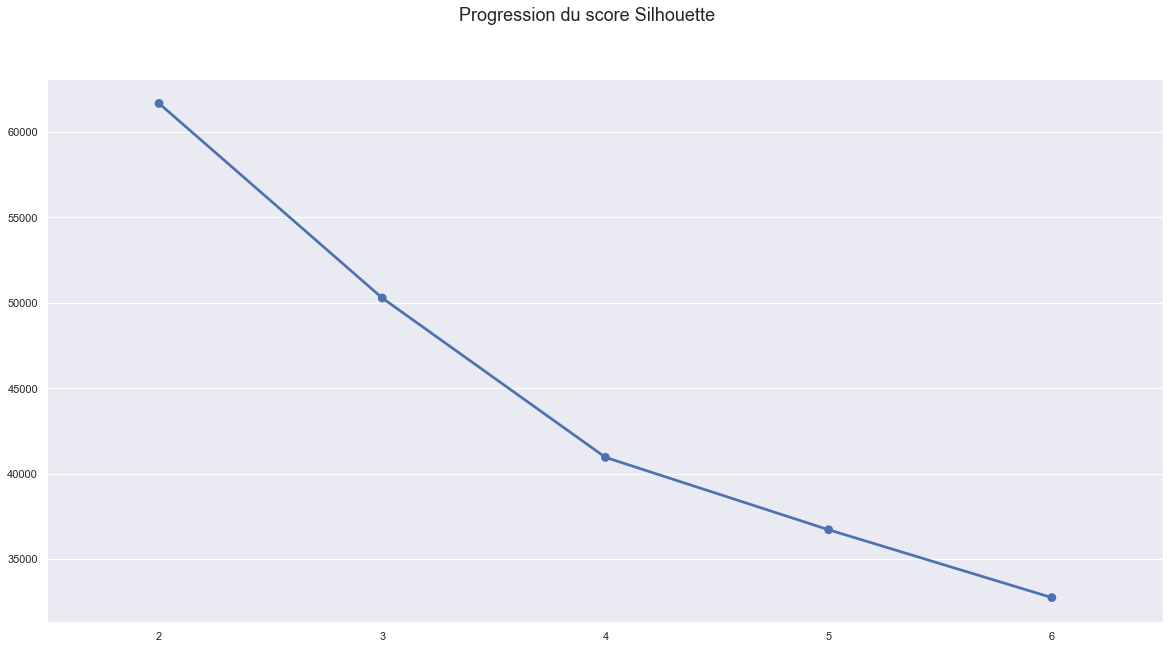

In [29]:
olist.scaler = StandardScaler()
olist.use_kmeans(data)

Comme précédemment le score silhouette propose 3 groupes et la méthode "Elbow" 4 groupes.

## Test avec 4 groupes

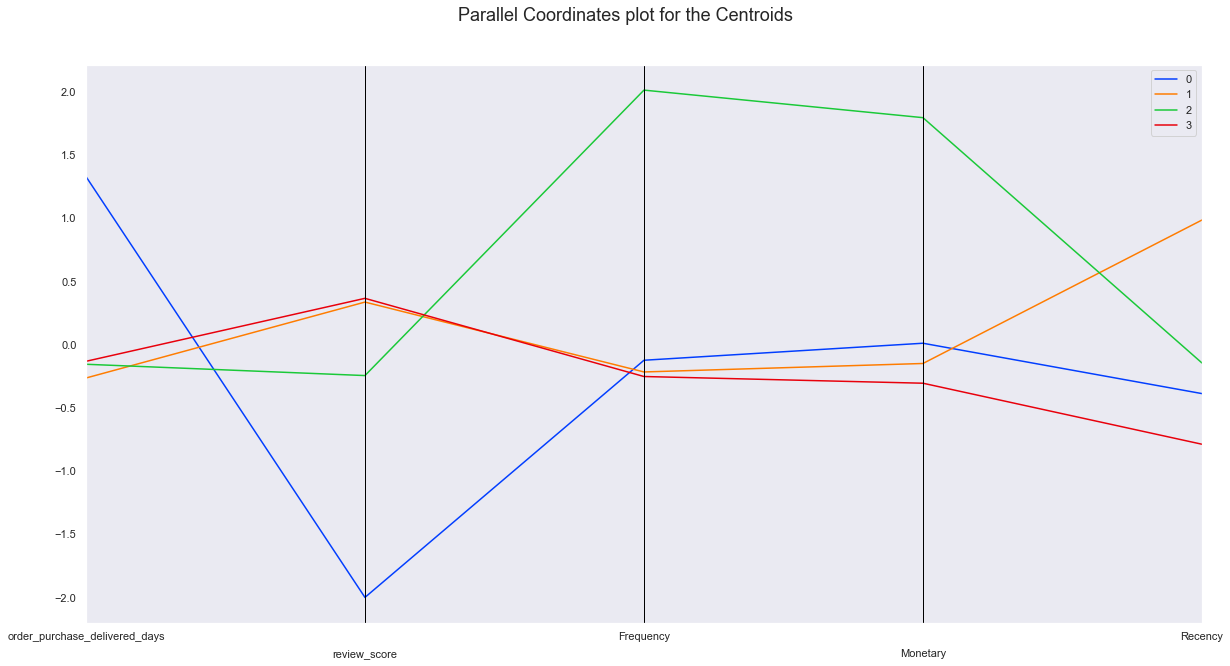

In [30]:
olist.scaler = StandardScaler()
olist.nb_cluster = 4
labels = olist.display_kmeans_centroids(data, image_name='none')
data['cluster'] = pd.Series(labels, index=data.index)

Text(0.5, 1.0, 'Normalisation Robust avec 4 groupes')

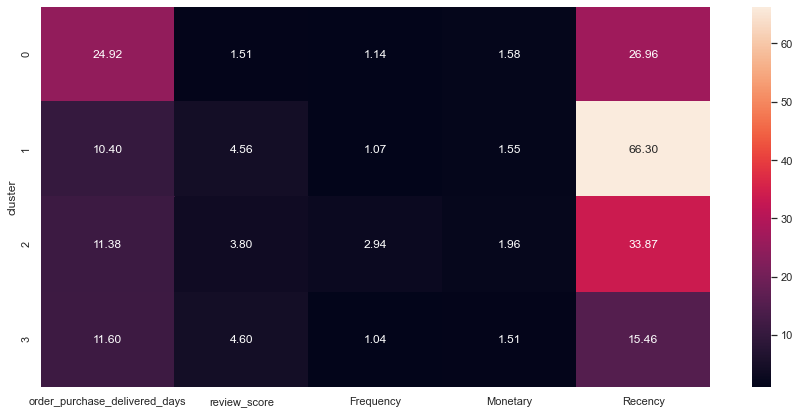

In [31]:
p0 = data.groupby('cluster').mean()
plt.subplots(figsize=(15, 7))
sns.heatmap(data=p0.sort_index(), annot=True, fmt='.2f')
ax1.set_title('Normalisation Robust avec 4 groupes', pad=20)

Découpage en 4 groupes :

**Groupe 0** :
 - Livraison rapide
 - Bonne note
 - Ne commande pas souvent
 - Faible montant
 - n'a pas commandé récemment
 
**Groupe 1** :
 - Livraison standard
 - Mauvaise note
 - Ne commande pas souvent
 - Montant moyen
 - n'a pas commandé récemment

**Groupe 2** :
 - Livraison rapide
 - Bonne note
 - Commande souvent
 - Montant importants
 - n'a pas commandé récemment

**Groupe 3** :
 - Livraison très lente
 - Mauvaise note
 - Ne commande pas souvent
 - Montant moyen
 - a commandé récemment

## Conclusion
En utilisation un algorithme de normalisation **standard** les groupes restent les même qu'avec une normalisation de type **MinMax**.

## Normalisation "robust"

In [32]:
features = [
    'order_purchase_delivered_days',
    'review_score',
    'Frequency',
    'Monetary',
    'Recency'
]
data = customer_data[features]
data.dropna(inplace=True)

Silhouette Score(n=2): 0.4845565596954568
Silhouette Score(n=3): 0.41672047465568357
Silhouette Score(n=4): 0.4152190347723495
Silhouette Score(n=5): 0.23620412385108047
Silhouette Score(n=6): 0.2493369769498816


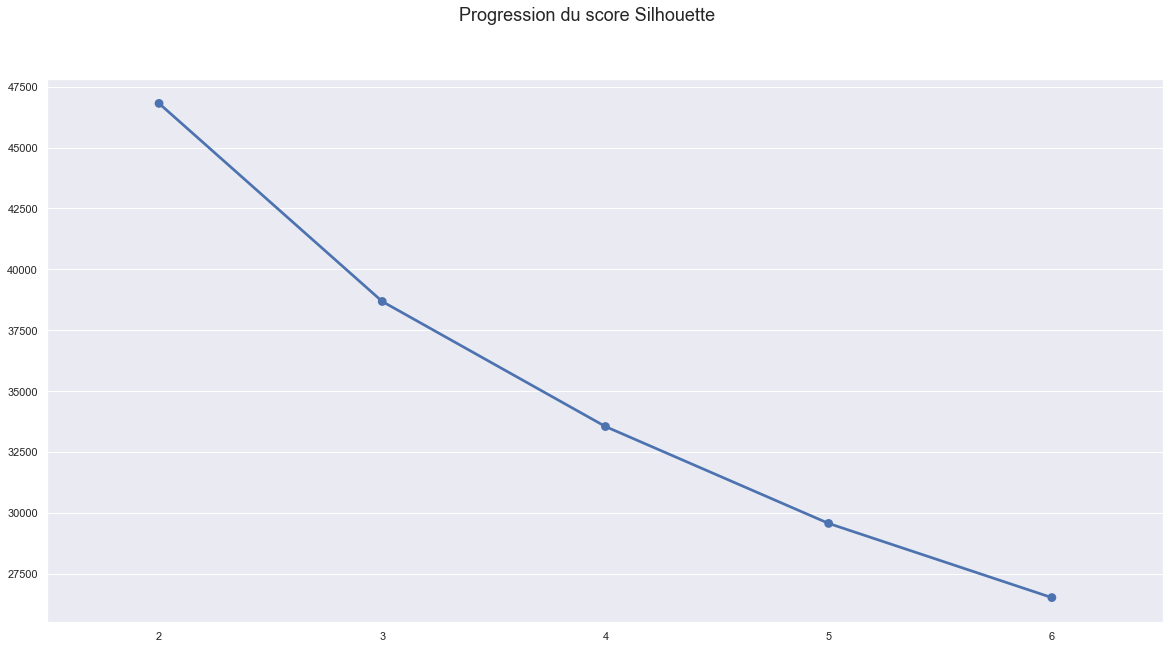

In [33]:
robust = RobustScaler()
olist.scaler = robust
olist.use_kmeans(data)

Le silhouette score propose 3 groupes et la méthode "elbow" semble proposer 3 groupes aussi.

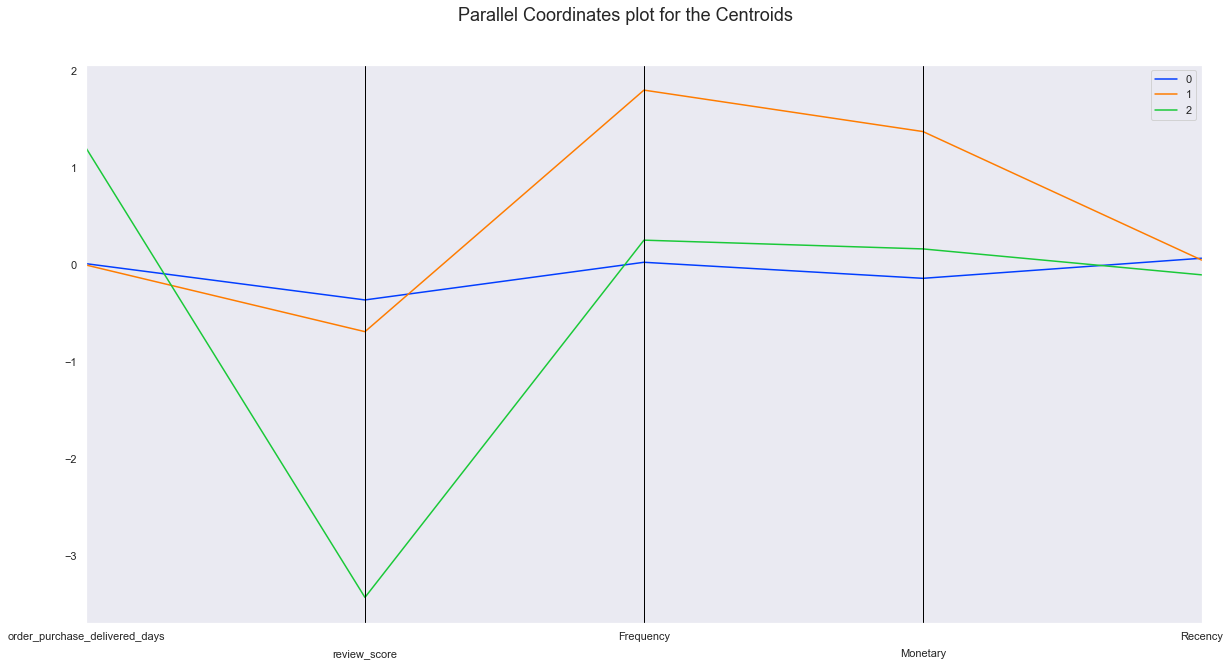

In [34]:
olist.nb_cluster = 3
labels = olist.display_kmeans_centroids(data, image_name='none')
data['cluster'] = pd.Series(labels, index=data.index)

Text(0.5, 1.0, 'Normalisation Robust avec 4 groupes')

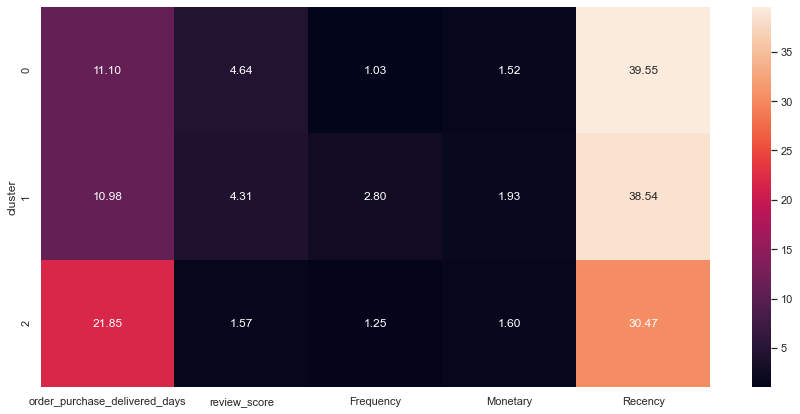

In [35]:
p0 = data.groupby('cluster').mean()
plt.subplots(figsize=(15, 7))
sns.heatmap(data=p0.sort_index(), annot=True, fmt='.2f')
ax1.set_title('Normalisation Robust avec 4 groupes', pad=20)

Découpage en 3 groupes :

**Groupe 0** :
 - Livraison rapide
 - Bonne note
 - Ne commande pas souvent
 - Faible montant
 - n'a pas commandé récemment
 
**Groupe 1** :
 - Livraison lente
 - Mauvaise note
 - commande peu souvent
 - Montant moyen
 - a commandé récemment

**Groupe 2** :
 - Livraison moyenne
 - note moyenne
 - Commande souvent
 - Montant important
 - n'a pas commandé récemment


## Conclusion
La normalisation de type **robust** avec 3 groupes est moins précise que l'utilisation de 4 groupes, mais va permettre de confirmer la pertinence des groupes. 

# DBSCAN
Utilisation d'un autre modèle de segmentation : DBSCAN. Les mêmes variables seront utilisées  

In [21]:
features = [
    'order_purchase_delivered_days',
    'review_score',
    'Frequency',
    'Monetary',
    'Recency'
]
data = customer_data[features]
data.dropna(inplace=True)

In [22]:
labels = olist.use_DBSCAN(data, eps=0.1, min_samples=10)

Estimation du nombre de clusters: 4
Estimation du nombre de points considrés comme du bruit: 191
Silhouette Score(n=4): 0.2599724474393806


Le silhouette score propose 4 groupes.

## Test avec 4 groupes

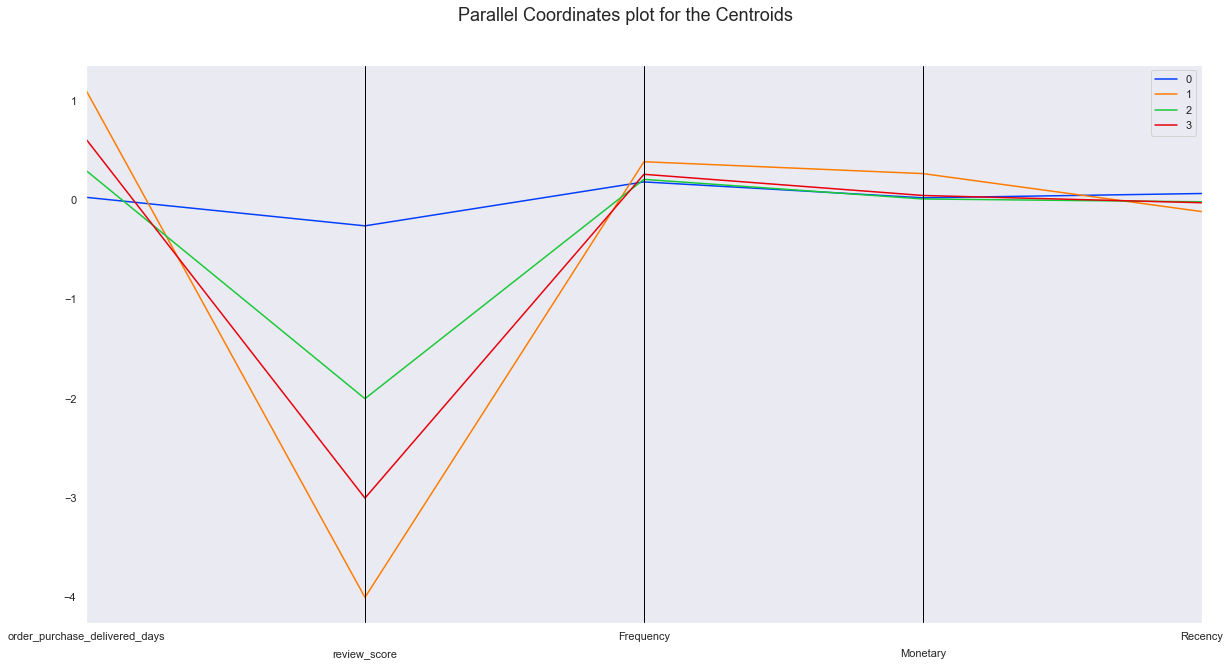

In [38]:
olist.nb_cluster = 4
olist.display_dbscan_core_points(data, labels, image_name='none')
data['cluster'] = pd.Series(labels, index=data.index)

Text(0.5, 1.0, 'DBSCAN avec 4 groupes')

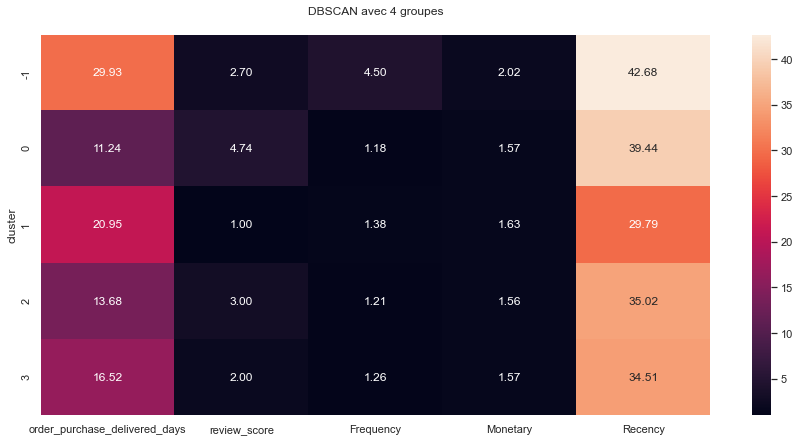

In [39]:
p0 = data.groupby('cluster').mean()
fig, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(data=p0.sort_index(), annot=True, fmt='.2f')
ax.set_title('DBSCAN avec 4 groupes', pad=20)

Découpage en 4 groupes :

**Groupe 0** :
 - Livraison rapide
 - Bonne note
 - Ne commande pas souvent
 - Faible montant
 - n'a pas commandé récemment
 
**Groupe 1** :
 - Livraison lente
 - Mauvaise note
 - commande peu souvent
 - Montant élevé
 - a commandé récemment

**Groupe 2** :
 - Livraison moyenne
 - bonne note
 - Commande peu souvent
 - Montant importants
 - n'a pas commandé récemment

**Groupe 3** :
 - Livraison moyenne
 - note moyenne
 - Commande souvent
 - Montant importants
 - n'a pas commandé récemment

## Conclusion
Le modèle DBSCAN propose 4 groupes, ceux-ci sont similaires au découpage en 4 groupes fait avec le modèle K-means, cependant de nombreuses observations sont considérées comme du bruit.

# Classification ascendante hiérarchique (CAH)

Utilisation d'un autre modèle de segmentation : CAH. Les mêmes variables seront utilisées  


In [40]:
olist.features = [
    'order_purchase_delivered_days',
    'review_score',
    'Frequency',
    'Monetary',
    'Recency'
]
data = customer_data[olist.features]
data.dropna(inplace=True)

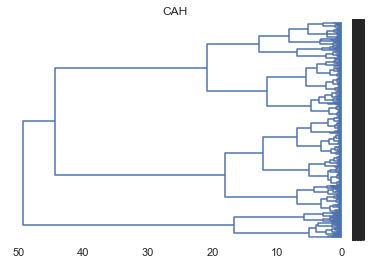

In [41]:
Z = olist.use_CAH(data)

L'analyse CAH permet de distinguer soit 2, 3 ou même 6 groupes. Il semble raisonnable de choisir 3 groupes, c'est à dire un découpage au seuil de 30.   

## Test avec 3 groupes

In [42]:
olist.nb_cluster = 25
groupes_cah = olist.display_CAH(data, Z)
data['cluster'] = pd.Series(groupes_cah, index=data.index)

Silhouette Score(n=3): 0.14885333710658746


In [43]:
clusters = data.groupby('cluster').mean()
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(clusters)
data_new = pd.DataFrame(data=data_scaled, index=["1", "2", "3"],
                        columns=[
                        'order_purchase_delivered_days',
                        'review_score',
                        'Frequency',
                        'Monetary',
                        'Recency'])

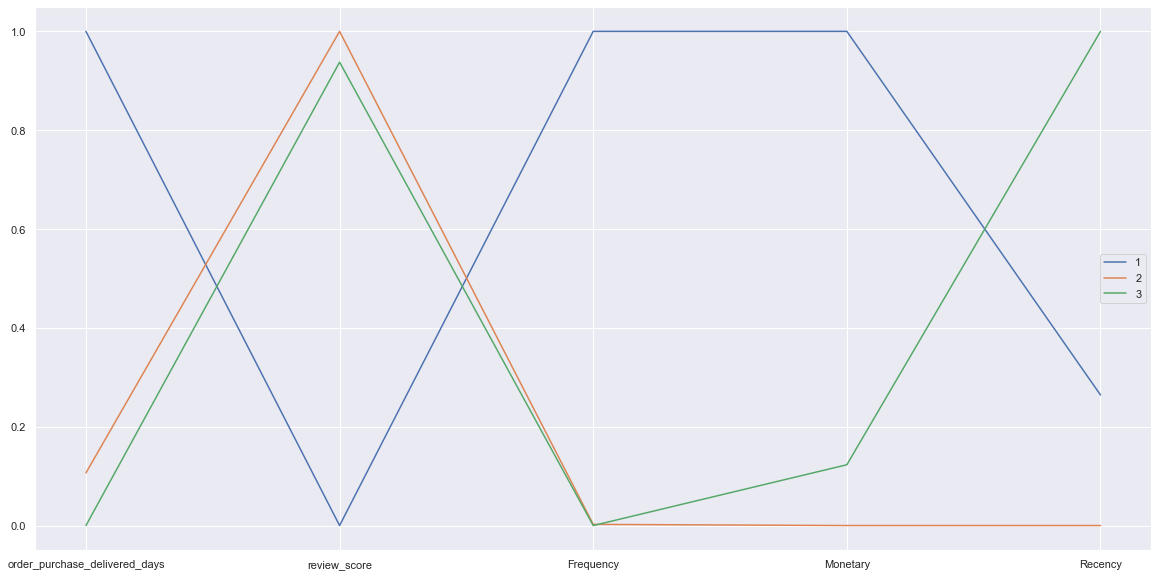

In [44]:
plt.figure(figsize=(20, 10))
plt.plot(data_new.T['1'], label="1")
plt.plot(data_new.T['2'], label="2")
plt.plot(data_new.T['3'], label="3")
plt.legend()
plt.show()

Text(0.5, 1.0, 'DBSCAN avec 4 groupes')

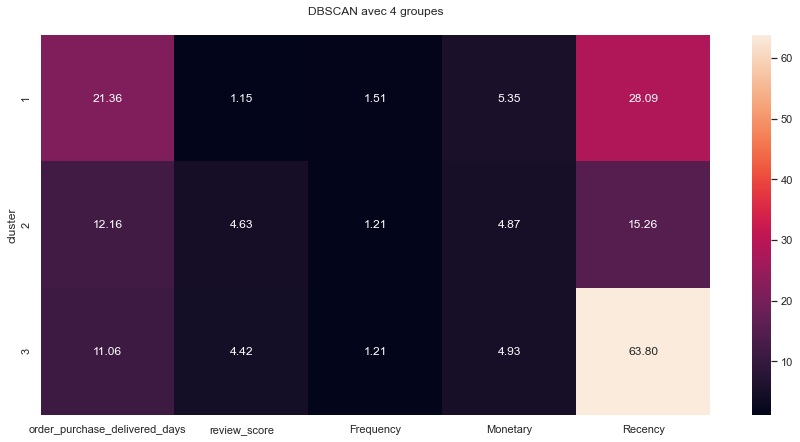

2:35: E231 missing whitespace after ','


In [45]:
p0 = data.groupby('cluster').mean()
fig, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(data=p0.sort_index(), annot=True, fmt='.2f')
ax.set_title('DBSCAN avec 4 groupes', pad=20)

**Groupe 1** :
 - Livraison lente
 - Mauvaise note
 - commande souvent
 - montant important
 - n'a pas commandé récemment
 
**Groupe 2** :
 - Livraison normale
 - bonne note
 - commande peu souvent
 - Montant moyen
 - a commandé récemment

**Groupe 3** :
 - Livraison rapide
 - bone note
 - Commande pas souvent
 - Montant moyen
 - n'a pas commandé récemment


## Conclusion
L'utilisation du modèle CAH montre un découpage similaire au K-means avec 3 groupes.

# Sélection du modèle


| Modèle | nb groupes | Silhouette | Elbow | Commentaire |
| :----- | ---------: | ---------: | ----: | :---------- |
| RFM    |            |            |       |             |
| K-means | 2          |  0,58      | 3     | Variables RFM uniquement|
| **K-means** | **2**          |  **0,48**      | **4**     | **5 variables**    |
| K-means | 2          |  0,48      | 3     | normalisation robust    |
| K-means | 2          |  0,38      | 4     | normalisation standard    |
| K-means | 2          |  0,31      | 4     | variables numériques   |
| CAH    | 3          |  0,28      |       |     |
| K-means | 3          |  0,26      | 3     | PCA    |
| DBSCAN | 5          |  0,24      |       |     |
| K-means | 2          |  0,07      | 4     | Toutes les variables    |


En suivant le score de Silhouette et la méthode "Elbow", le modèle avec 4 groupes et 5 variables semble le plus adapté.


# Conlusion
Le modèle choisi est un K-means avec 5 variables, une normalisation de type "MinMax" et une segmentation en 3 groupes.

Les variables retenues sont :
 - Délai moyen entre la commande et la livraison (purchase_delivered)
 - Moyenne de la récence (Recency)
 - Moyenne des notes d'appréciation (review_score)
 - Moyenne de la fréquence (Frequency)
 - Montant total moyen (Monetary)

**Groupe 0** :
 - Livraison rapide
 - Bonne note
 - Ne commande pas souvent
 - Faible montant
 - n'a pas commandé récemment
 
**Groupe 1** :
 - Livraison standard
 - Mauvaise note
 - Ne commande pas souvent
 - Montant moyen
 - n'a pas commandé récemment

**Groupe 2** :
 - Livraison rapide
 - Bonne note
 - Commande souvent
 - Montant important
 - n'a pas commandé récemment

**Groupe 3** :
 - Livraison très lente
 - Mauvaise note
 - Ne commande pas souvent
 - Montant moyen
 - a commandé récemment
   
![](img/segmentation.png)


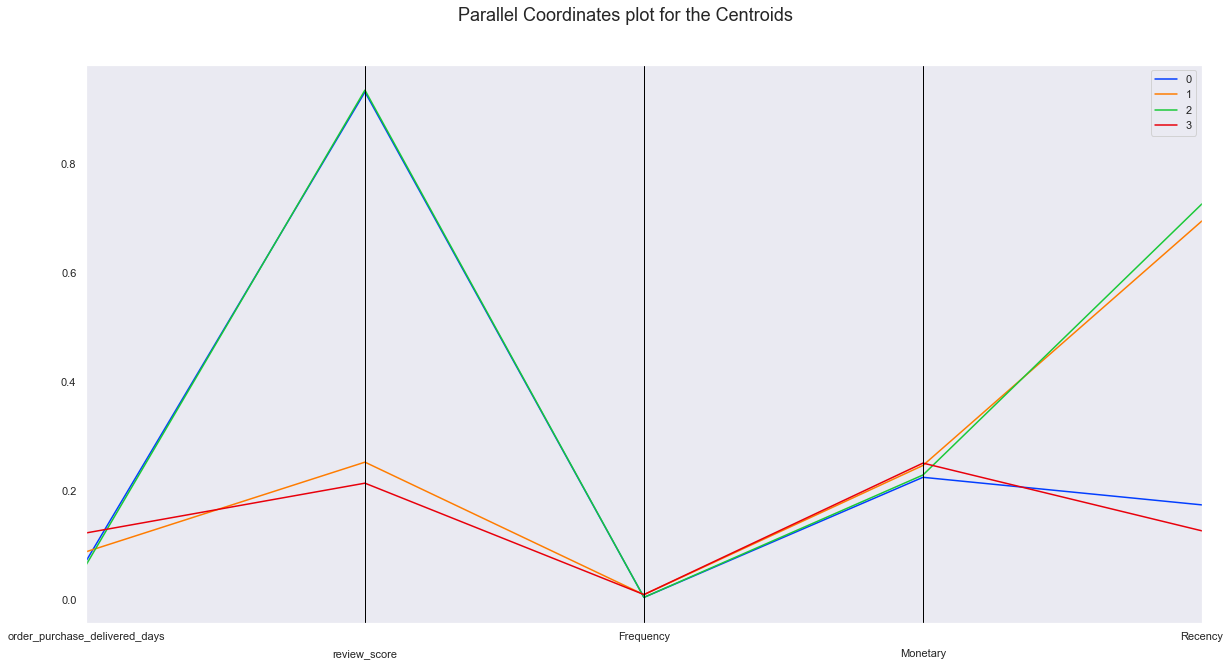

In [46]:
features = [
    'order_purchase_delivered_days',
    'review_score',
    'Frequency',
    'Monetary',
    'Recency'
]
data = customer_data[features]
data.dropna(inplace=True)
olist.nb_cluster = 4
olist.scaler = MinMaxScaler()

labels = olist.display_kmeans_centroids(data, image_name='none')
data['cluster'] = pd.Series(labels, index=data.index)

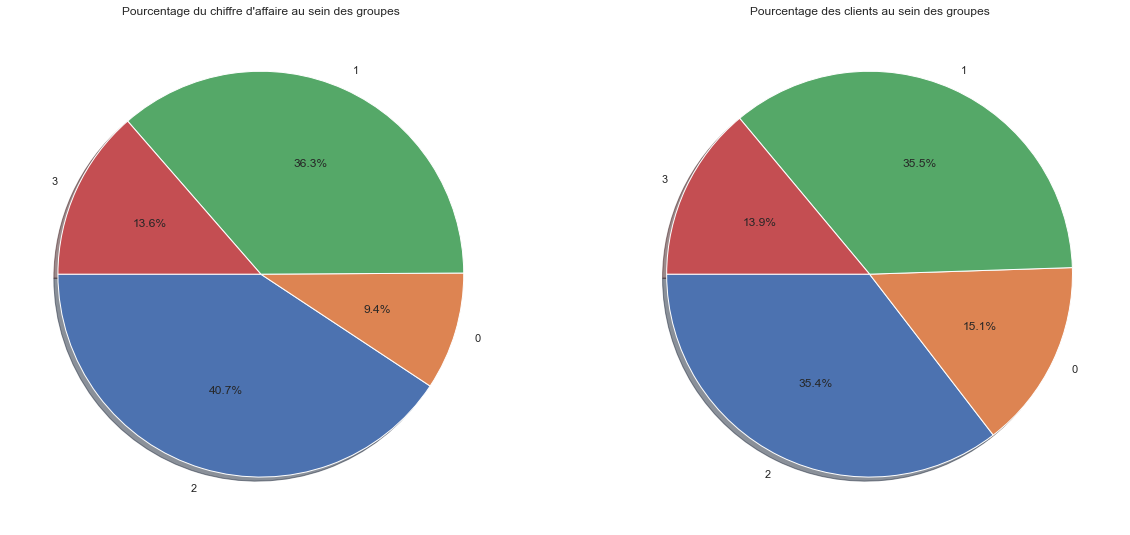

In [47]:
olist.display_customers(data, data['cluster'].unique(), 'Monetary')

Le groupe **Petits clients** (0) représente 15% des clients et 9% du chiffre d'affaires

Le groupe **Anciens bons clients** (1) représente 35% des clients et 36% du chiffre d'affaires

Le groupe **Anciens petits clients** (2) représente 35% des clients et 41% du chiffre d'affaires

Le groupe **Bons clients** (3) représente 35% des clients et 41% du chiffre d'affaires